In [27]:
!python "04_trading_lstm_chatgpt.py"

In [1]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer, LightningModule
from lightning.pytorch.callbacks import ModelCheckpoint

wandb_logger = WandbLogger(log_model="all", project="traiding_lstm_01")

trainer = Trainer(logger=wandb_logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tqdm

In [4]:
import os 
os.environ['WANDB_NOTEBOOK_NAME'] = "/home/shmalex/data1t/projects/andrey/jn/04_trading_lstm_chatgpt.ipynb"

In [5]:
torch.__version__

'2.0.1+cu117'

In [6]:
# # Create a simple LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.dropout(out[:, -1, :])  # Take only the output of the last time step
#         out = self.fc(out)
#         return out


In [7]:

# Here we define our model as a class
# class LSTM(nn.Module):
    
class LSTM(LightningModule):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.save_hyperparameters()


        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [8]:
# Prepare data for training
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [9]:
df = pd.read_csv('../data/MNQ DEC23.Last-500-Volume-Action.txt')
df.head()

,date,open,high,low,close,vol,ft,action
0,2023-10-02 22:00:38,14992.00,14992.25,14986.50,14989.50,500,-0.342828,0
1,2023-10-02 22:03:41,14989.75,14992.50,14988.25,14990.50,500,-0.062081,0
2,2023-10-02 22:08:04,14991.00,14992.75,14989.50,14992.00,500,0.396141,0
3,2023-10-02 22:13:26,14992.00,14995.00,14987.75,14989.75,500,0.204056,0
4,2023-10-02 22:14:44,14989.75,14999.00,14989.75,14997.50,500,0.449363,0


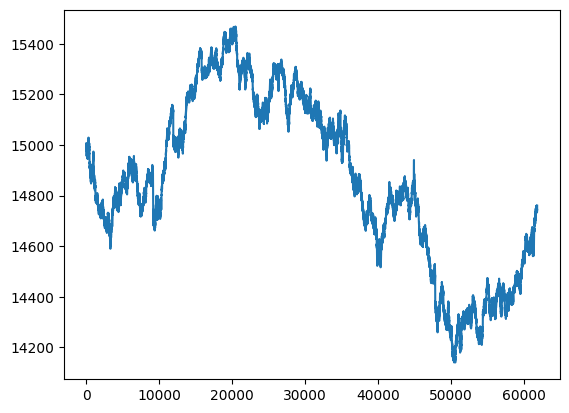

In [10]:
plt.plot(df['close'])
plt.show()

In [11]:
# Preprocess the data
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_scaled = scaler.fit_transform(df[['close']].values)

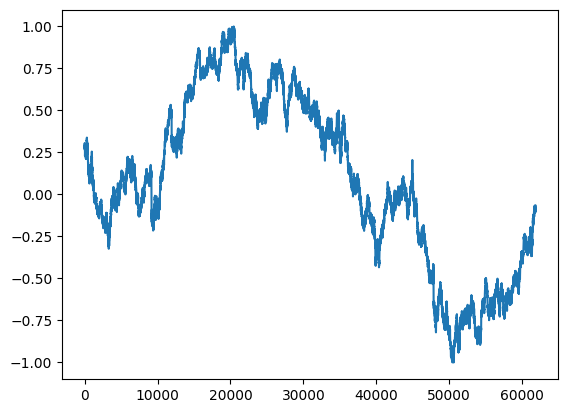

In [12]:
plt.plot(prices_scaled)

In [13]:
seq_length = 59
X, y = create_sequences(prices_scaled, seq_length)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)

# AAAAAAAAAAAAAAAAAAAA fcking shape!
y = torch.tensor(y, dtype=torch.float32).reshape((-1,1))


test_set_size = int(np.round(0.2*X.shape[0]));
train_set_size = X.shape[0] - (test_set_size);


X_train = X[:train_set_size]
y_train = y[:train_set_size]
X_test = X[train_set_size:]
y_test = y[train_set_size:]


print('X_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('X_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)


# add one parameter
wandb_logger.experiment.config["data_shape"] = X.shape

# add multiple parameters
wandb_logger.experiment.config.update({
                                        "X_train":X_train.shape,
                                        "y_train":y_train.shape,
                                        "X_test":X_test.shape,
                                        "y_test":y_test.shape})

X_train.shape =  torch.Size([49419, 59, 1])
y_train.shape =  torch.Size([49419, 1])
X_test.shape =  torch.Size([12355, 59, 1])
y_test.shape =  torch.Size([12355, 1])


wandb: Currently logged in as: amatusevski. Use `wandb login --relogin` to force relogin


In [14]:
torch.min(X), torch.max(X)

(tensor(-1.), tensor(1.))

In [15]:
# validation
print(X.shape, y.shape)

for u in range(1000):
    assert y[u] == X[u+1][-1][0]
print('All good')

torch.Size([61774, 59, 1]) torch.Size([61774, 1])
All good


In [16]:
# Configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

weight = np.ones(seq_length)/np.array(range(1,seq_length+1))
weight = torch.FloatTensor(weight).to(device)
weight

plt.plot(weight.to('cpu'))


class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return ((input - target)**2 ) * weight


weight=torch.FloatTensor([2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

mse_criterion = weighted_MSELoss()
loss_mot_rec = mse_criterion(self.fake_noise,self.real_noise,weights).mean(dim = -1)

def weighted_mse_loss(input, target):
    
    return (weight * (input - target) ** 2)


?LSTM

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

for idx, (batch_X, batch_y) in enumerate(train_loader):
    print(idx)
    print(batch_X.shape)
    break

batch_X[0].reshape(-1),batch_X[1].reshape(-1)

In [17]:
# Hyperparameters
input_size = 1 # number of features
hidden_size = 40 #
num_layers = 3
output_size = 1
num_epochs = 10
learning_rate = 0.01
batch_size = 128

In [18]:
# Initialize model, loss function, and optimizer
model = LSTM(input_dim=input_size, 
             hidden_dim=hidden_size,
             output_dim=output_size,
             num_layers=num_layers).to(device)
# https://discuss.pytorch.org/t/how-to-implement-weighted-mean-square-error/2547/6
criterion = nn.MSELoss() # <<<
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [20]:
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

NameError: name 'model' is not defined

for idx, (train_index, test_index) in enumerate(tqdm.tqdm_notebook(tscv.split(X))):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

u_out = model.fc1(batch_X)

batch_X.shape

u_out.shape

u_out.shape

u_out[0]

u_out[:,-1,:]

model.fc2(u_out)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# train_data   = torch.utils.data.TensorDataset(X, y)
# train_loader = torch.utils.data.DataLoader(dataset=train_data,
#                                                batch_size=batch_size,
#                                                shuffle=True)
# Train model
#####################
num_epochs = 100
hist = []
# hist = np.zeros((int(len(train_data)/128)+1)*num_epochs)

# Number of steps to unroll
seq_dim =60
batch_size=512
t = 0
# model.train()
for t in tqdm.tqdm_notebook(range(num_epochs)):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    train_data = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    for batch_X, batch_y in train_loader:
        t+=1
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # Forward pass
        y_train_pred = model(batch_X)

        loss = criterion(y_train_pred, batch_y)
        if t % 100 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())

        model.log("train_loss",loss.item())
        hist.append(loss.item())

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

0it [00:00, ?it/s]

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Train Idx [0:8238] 
Test  Idx [8239:16474]


  0%|          | 0/10 [00:00<?, ?it/s]

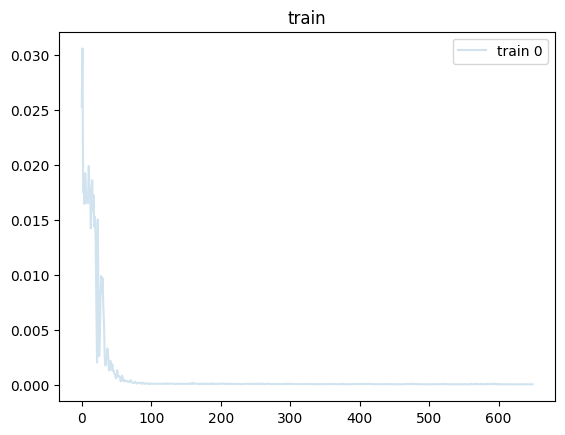

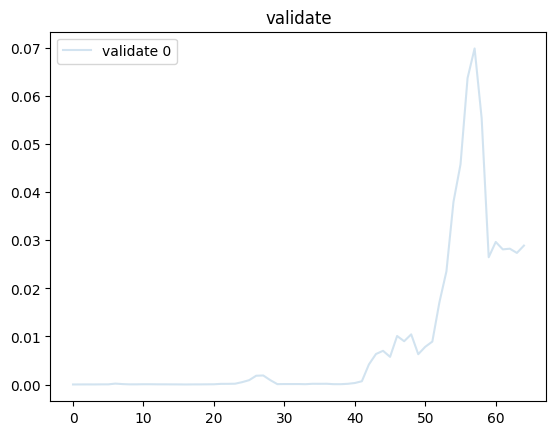

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Train Idx [0:16474] 
Test  Idx [16475:24710]


  0%|          | 0/10 [00:00<?, ?it/s]

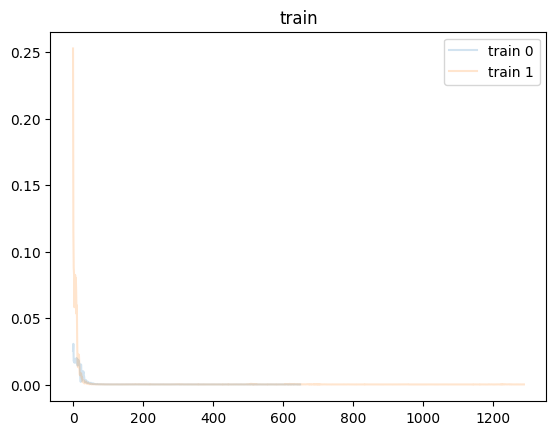

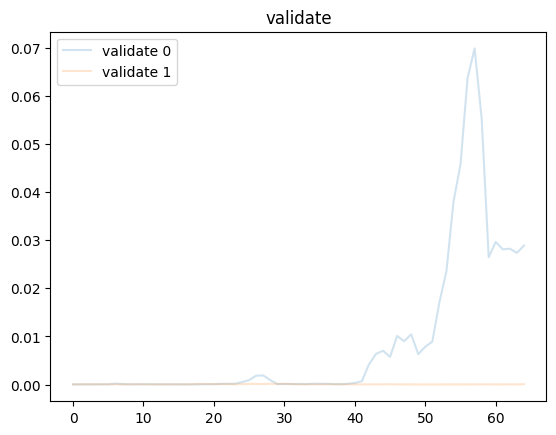

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Train Idx [0:24710] 
Test  Idx [24711:32946]


  0%|          | 0/10 [00:00<?, ?it/s]

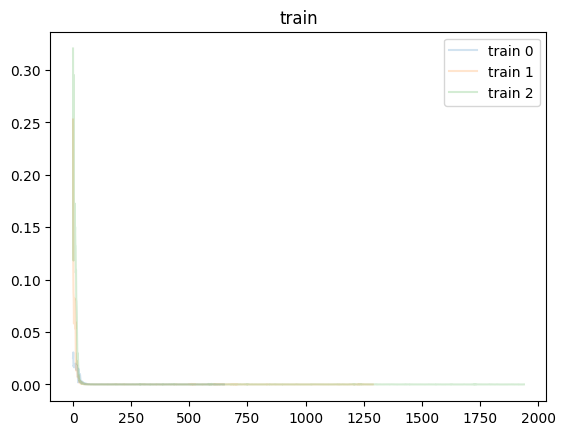

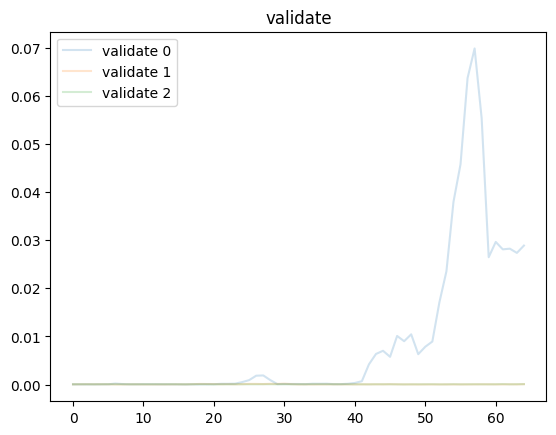

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Train Idx [0:32946] 
Test  Idx [32947:41182]


  0%|          | 0/10 [00:00<?, ?it/s]

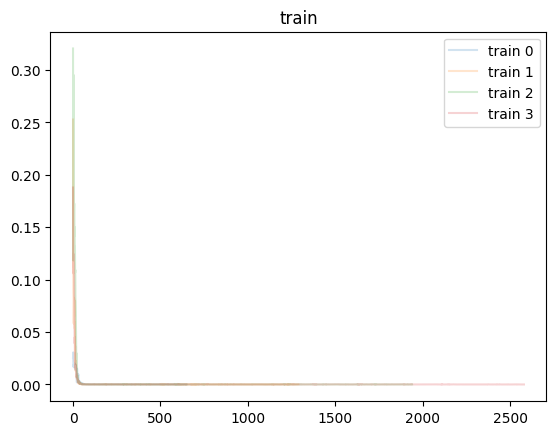

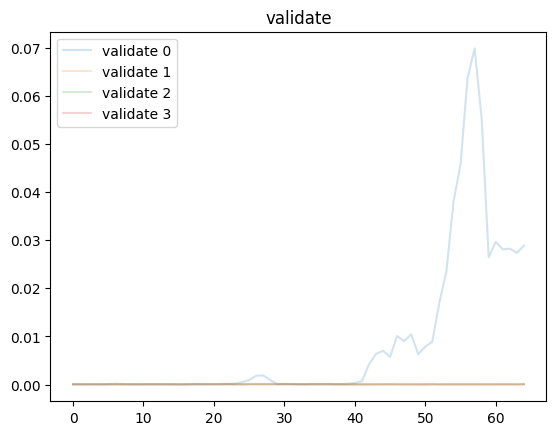

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Train Idx [0:41182] 
Test  Idx [41183:49418]


  0%|          | 0/10 [00:00<?, ?it/s]

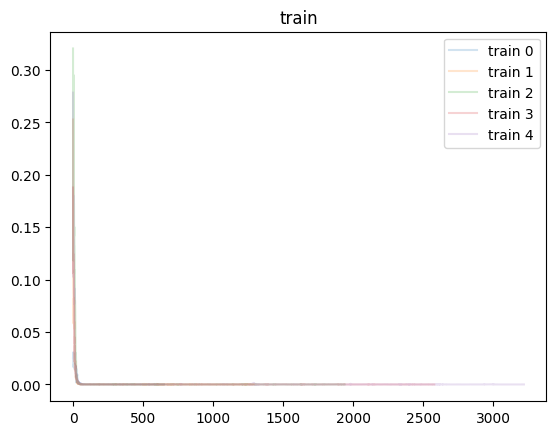

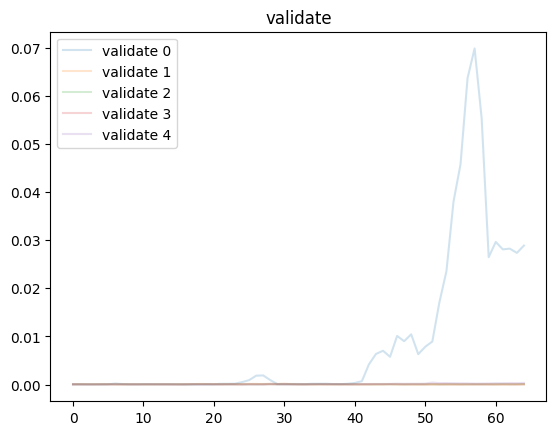

In [22]:
losses = []
losses_after = []
# Training loop
i = 0
step = 0
# N split cross validation
for idx, (train_index, test_index) in enumerate(tqdm.tqdm_notebook(tscv.split(X_train))):    
    model = LSTM(input_dim=input_size, 
             hidden_dim=hidden_size,
             output_dim=output_size,
             num_layers=num_layers).to(device)
    wandb_logger.watch(model)
    #     model = LSTM(input_size=input_size,
    #                  hidden_size=hidden_size,
    #                  num_layers=num_layers,
    #                  output_size=output_size).to(device)
    #      input_dim, hidden_dim, num_layers, output_dim
    criterion = torch.nn.MSELoss()

    # https://discuss.pytorch.org/t/how-to-implement-weighted-mean-square-error/2547/6
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    print(f'Train Idx [{min(train_index)}:{max(train_index)}] ')
    print(f'Test  Idx [{min(test_index)}:{max(test_index)}]')
    fold_X_train, fold_X_test = X_train[train_index], X_train[test_index]
    fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

    # Convert to DataLoader for easy batching
    fold_train_data   = torch.utils.data.TensorDataset(fold_X_train, fold_y_train)
    fold_train_loader = torch.utils.data.DataLoader(dataset=fold_train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    
    for epoch in tqdm.tqdm_notebook(range(num_epochs), leave=False):
        for fold_batch_X, fold_batch_y in fold_train_loader:
            step+=1
            i+=1
            fold_batch_X, fold_batch_y = fold_batch_X.to(device), fold_batch_y.to(device)

            # Backward and optimize
            # Forward pass
            fold_batch_X_pred = model(fold_batch_X)
#             if i%10==0:
#                 print(fold_batch_X_pred.reshape(-1).cpu().detach().numpy()[:10])
            loss = criterion(fold_batch_X_pred, fold_batch_y)
            losses.append([loss.item(), 0, idx])
            wandb_logger.log("trainer/train_loss",loss.item())#, {"trainer/global_step": step})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#         if (epoch+1) % 50 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        fold_val_test_data   = torch.utils.data.TensorDataset(fold_X_test, fold_y_test)
        fold_val_test_loader = torch.utils.data.DataLoader(dataset=fold_val_test_data,
                                                  batch_size=batch_size,
                                                  shuffle=False)

        predictions = []
        for fold_val_batch_X, fold_val_batch_y in fold_val_test_loader:
            step+=1
            fold_val_batch_X, fold_val_batch_y = fold_val_batch_X.to(device), fold_val_batch_y.to(device)
            fold_val_batch_X_pred = model(fold_val_batch_X)
            # predictions.extend(outputs.cpu().numpy())
            loss = criterion(fold_val_batch_X_pred, fold_val_batch_y)
#             print(loss.item())
            losses.append([loss.item(), 1, idx])
            wandb_logger.log("trainer/val_loss",loss.item())#, {"trainer/global_step": step})
    
#             checkpoint_callback = ModelCheckpoint(monitor="val_accuracy", mode="max")


#     model.train()

    for iidx in range(idx+1):
        plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==iidx) &(x[1]==0), losses) )),
                 label=f'train {iidx}', alpha=0.2)
    plt.legend()
    plt.title(f'train')
    # plt.savefig(f'./train_{idx}.jpg')
    plt.show()

    for iidx in range(idx+1):
        plt.plot(list(map(lambda x: x[0],filter(lambda x: (x[2]==iidx) &(x[1]==1), losses) )),
                    label=f'validate {iidx}', alpha=0.2)
    plt.legend()
    plt.title(f'validate')
    plt.show()
#     break


In [23]:
model.eval()

LSTM(
  (lstm): LSTM(1, 40, num_layers=3, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)

In [24]:

X_test_pred = model(X_test.to(device)).cpu()
X_test_pred.shape

X_test_loss = criterion(X_test_pred, y_test)
print("X Test Loss:",X_test_loss.item())

X Test Loss: 0.0002526583266444504


In [25]:
X_test_pred = X_test_pred.detach().numpy()

In [26]:
X_test_pred.shape

(12355, 1)

In [42]:
X_test_pred_inv = scaler.inverse_transform(X_test_pred)
y_test_inv = scaler.inverse_transform(y_test)

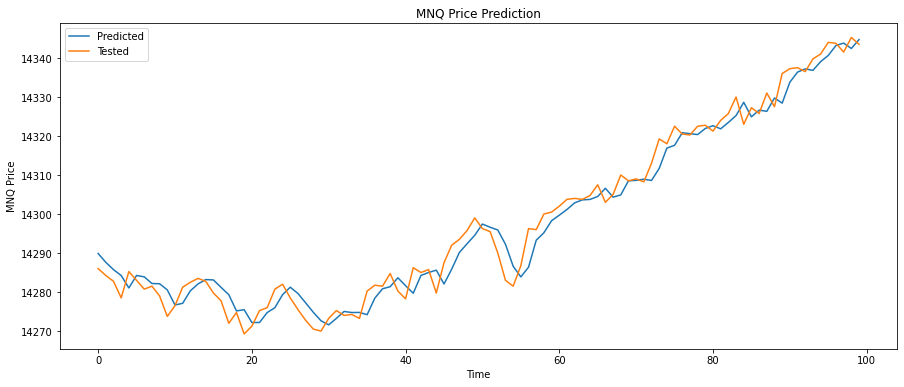

In [53]:
figure, axes = plt.subplots(figsize=(15, 6))
I = 0
N = 100
axes.plot(X_test_pred_inv[I:I+N]+30, label='Predicted')
axes.plot(y_test_inv[I:I+N], label='Tested')
plt.title('MNQ Price Prediction')
plt.xlabel('Time')
plt.ylabel('MNQ Price')
plt.legend()
# plt.savefig('ibm_pred.png')
plt.show()

In [122]:
X_test[10].reshape(-1)

tensor([-0.7341, -0.7345, -0.7307, -0.7224, -0.7292, -0.7292, -0.7288, -0.7224,
        -0.7250, -0.7345, -0.7326, -0.7379, -0.7439, -0.7522, -0.7492, -0.7458,
        -0.7473, -0.7371, -0.7439, -0.7488, -0.7556, -0.7563, -0.7465, -0.7522,
        -0.7522, -0.7631, -0.7638, -0.7680, -0.7706, -0.7718, -0.7687, -0.7695,
        -0.7638, -0.7635, -0.7695, -0.7627, -0.7635, -0.7631, -0.7605, -0.7687,
        -0.7691, -0.7695, -0.7763, -0.7827, -0.7838, -0.7812, -0.7770, -0.7770,
        -0.7751, -0.7812, -0.7838, -0.7861, -0.7925, -0.7823, -0.7857, -0.7891,
        -0.7879, -0.7917, -0.7996])

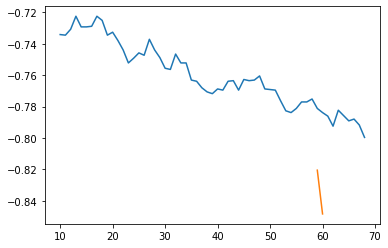

In [149]:
pred_shift = 0
pred_size = 10
__len = X_test.shape[1]

predictions = []
new_data = X_test[[pred_shift]]

for i in range(pred_size):
    data_pred = model(new_data.to(device)).cpu()
    predictions.append(data_pred.detach().numpy()[0][0])
    new_data = np.concatenate([new_data.reshape(-1),data_pred.detach().numpy()[0]])
    # print(predictions,X_test[pred_shift+i+1][-1].detach().numpy()[0])
    # print(new_data)
    new_data = new_data[1:].reshape(1,__len,1)
    new_data = torch.tensor(new_data, dtype=torch.float32)
# plt.plot(X_test[pred_shift])
__x = 10
plt.plot(range(__x,__len+__x),X_test[__x])
plt.plot(range(__len,len(predictions)+__len), predictions)
plt.show()

In [94]:
predictions = np.array(predictions)

In [97]:
predictions_inv = scaler.inverse_transform(predictions.reshape((10,1))).reshape(-1)
predictions_inv

array([14259.883, 14241.388, 14223.929, 14207.994, 14193.166, 14179.278,
       14166.265, 14154.1  , 14142.76 , 14132.229], dtype=float32)

In [105]:
X_inv = X_test[59]
X_inv = scaler.inverse_transform(X_inv).reshape(-1)
X_inv

array([14285.99998799, 14284.25001626, 14282.75000092, 14278.49999045,
       14285.2500001 , 14282.99999689, 14280.74999367, 14281.49998155,
       14278.99998237, 14273.74998805, 14276.49998319, 14281.24998559,
       14282.50000496, 14283.49998881, 14282.75000092, 14279.75000982,
       14277.75000256, 14272.00001632, 14274.75001146, 14269.24998161,
       14271.24998887, 14275.25000338, 14275.99999127, 14280.74999367,
       14282.00001304, 14278.49999045, 14275.49999934, 14272.7500042 ,
       14270.50000098, 14270.00000906, 14273.24999613, 14275.25000338,
       14273.99998401, 14274.25001954, 14273.24999613, 14280.25000174,
       14281.75001708, 14281.49998155, 14284.75000818, 14280.25000174,
       14278.24999449, 14286.24998395, 14285.00000414, 14285.74999203,
       14279.75000982, 14287.50000332, 14292.00000976, 14293.49998553,
       14295.74998875, 14299.00001538, 14296.24998067, 14295.49999279,
       14290.0000025 , 14282.99999689, 14281.49998155, 14286.75001544,
      

In [114]:
predictions

array([-0.8205153 , -0.84838045, -0.87468445, -0.89869034, -0.9210298 ,
       -0.9419546 , -0.9615593 , -0.9798881 , -0.996971  , -1.0128391 ],
      dtype=float32)

In [113]:
X_test[10]

tensor([[-0.7341],
        [-0.7345],
        [-0.7307],
        [-0.7224],
        [-0.7292],
        [-0.7292],
        [-0.7288],
        [-0.7224],
        [-0.7250],
        [-0.7345],
        [-0.7326],
        [-0.7379],
        [-0.7439],
        [-0.7522],
        [-0.7492],
        [-0.7458],
        [-0.7473],
        [-0.7371],
        [-0.7439],
        [-0.7488],
        [-0.7556],
        [-0.7563],
        [-0.7465],
        [-0.7522],
        [-0.7522],
        [-0.7631],
        [-0.7638],
        [-0.7680],
        [-0.7706],
        [-0.7718],
        [-0.7687],
        [-0.7695],
        [-0.7638],
        [-0.7635],
        [-0.7695],
        [-0.7627],
        [-0.7635],
        [-0.7631],
        [-0.7605],
        [-0.7687],
        [-0.7691],
        [-0.7695],
        [-0.7763],
        [-0.7827],
        [-0.7838],
        [-0.7812],
        [-0.7770],
        [-0.7770],
        [-0.7751],
        [-0.7812],
        [-0.7838],
        [-0.7861],
        [-0.

59

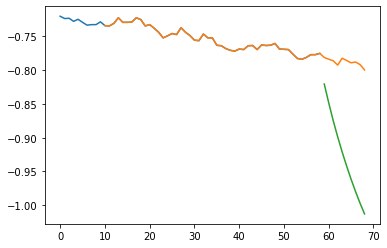

In [83]:
X_test_pred.

tensor([[-0.8205]], grad_fn=<CopyBackwards>)

In [77]:
X_test_pred.detach().numpy()[0]

array([-0.8205153], dtype=float32)

(1, 59, 1)

array([-0.8205153], dtype=float32)

In [17]:
losses_1 = list(filter(lambda x: x[1]==0,losses))
losses_1 = np.array(losses_1)

In [18]:
len(losses_after)

15250

In [19]:
losses_after = np.array(losses_after)

In [20]:
np.sum(losses_1[::,0] - losses_after[::,0])

0.0

In [87]:
for batch_X, batch_y in test_loader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    outputs = model(batch_X)
    # predictions.extend(outputs.cpu().numpy())
    loss = criterion(outputs, batch_y)
    break
#             print(loss.item())

#     losses.append([loss.item(), 1,idx])

In [88]:
outputs.shape

torch.Size([256, 1])

In [158]:
local_loss = []
for idx in range(63):
    local_loss.append([batch_y[idx].to('cpu').reshape((-1,)).detach().numpy()[0], outputs[idx].to('cpu').detach().numpy()[0]])

In [159]:
u = np.array(local_loss)
_yhat = u[::,0]
_y = u[::,1]

In [160]:
loss

tensor(0.1520, device='cuda:0')

In [161]:
((_yhat-_y)**2).mean()

0.15195942

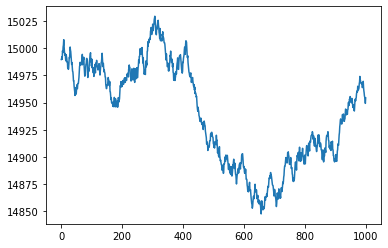

In [93]:
plt.plot(df['close'].values[:1000])

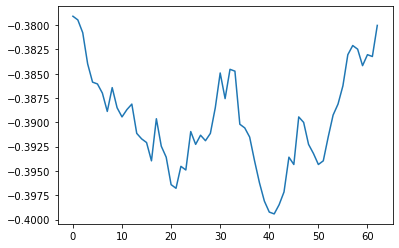

In [162]:
plt.plot(_yhat-_y)
plt.show()

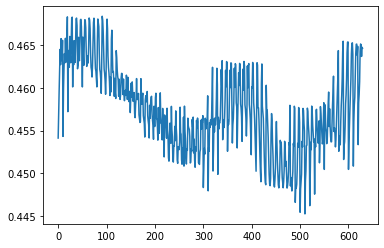

In [26]:
plt.plot(outputs.reshape((-1,)).to('cpu').detach().numpy())

In [45]:
outputs.shape

torch.Size([63, 10, 1])

In [50]:
np.mean(outputs.item(), axis=1)

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
 for fold_val_batch_X, fold_val_batch_y in fold_val_test_loader:
            fold_val_batch_X, fold_val_batch_y = fold_val_batch_X.to(device), fold_val_batch_y.to(device)
            fold_val_batch_X_pred = model(fold_val_batch_X)
            # predictions.extend(outputs.cpu().numpy())
            loss = criterion(fold_val_batch_X_pred, fold_val_batch_y)
#             print(loss.item())
            losses.append([loss.item(), 1, idx])

In [21]:
fold_val_batch_X_pred

tensor([[-0.0822],
        [-0.0773],
        [-0.0812],
        [-0.0834],
        [-0.0819],
        [-0.0805],
        [-0.0867],
        [-0.0881],
        [-0.0886],
        [-0.0923],
        [-0.0837],
        [-0.0891],
        [-0.0918],
        [-0.0975],
        [-0.0982],
        [-0.0934],
        [-0.0940],
        [-0.0862],
        [-0.0888],
        [-0.0872],
        [-0.0883],
        [-0.0867],
        [-0.0813],
        [-0.0739],
        [-0.0794],
        [-0.0737],
        [-0.0738],
        [-0.0849],
        [-0.0860],
        [-0.0875],
        [-0.0923],
        [-0.0970],
        [-0.1008],
        [-0.1030],
        [-0.1033],
        [-0.1013],
        [-0.0986],
        [-0.0914],
        [-0.0929],
        [-0.0833],
        [-0.0842],
        [-0.0891],
        [-0.0912],
        [-0.0932],
        [-0.0924],
        [-0.0873],
        [-0.0826],
        [-0.0805],
        [-0.0769],
        [-0.0704],
        [-0.0684],
        [-0.0693],
        [-0.

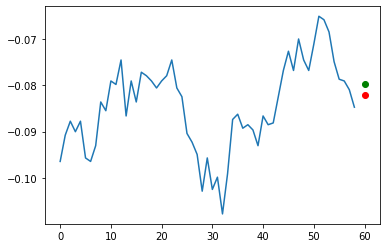

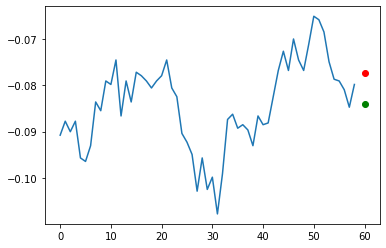

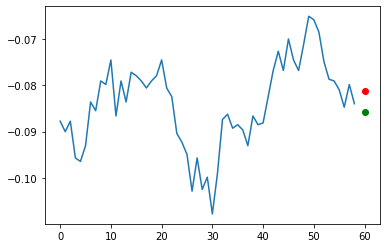

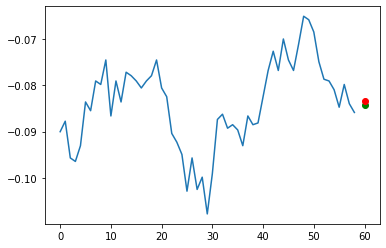

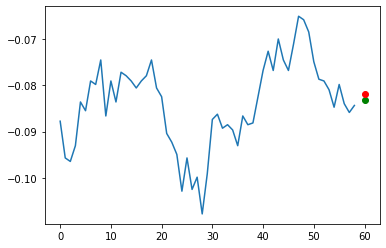

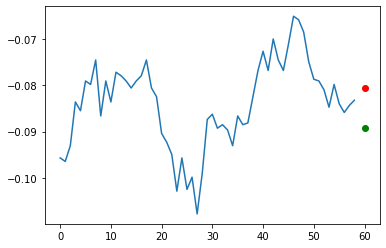

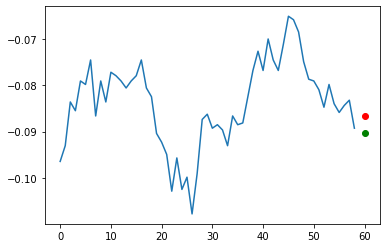

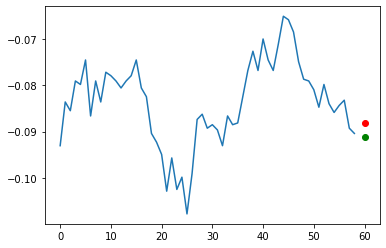

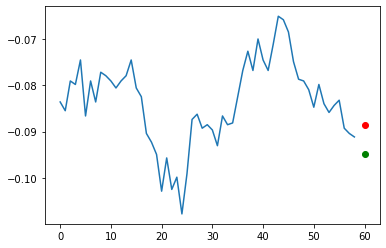

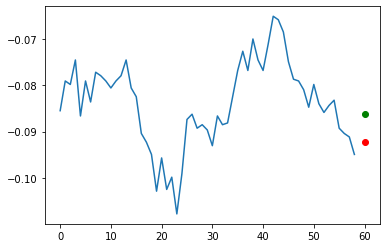

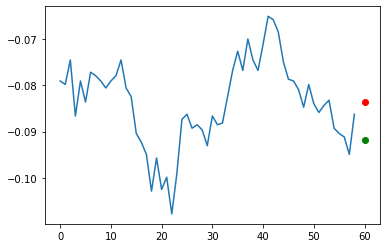

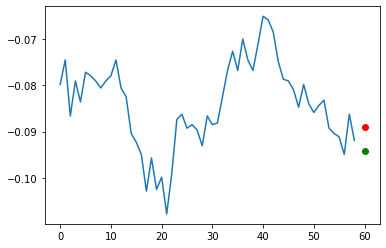

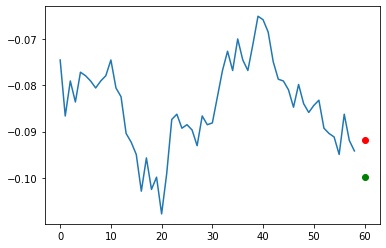

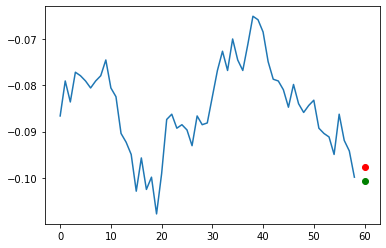

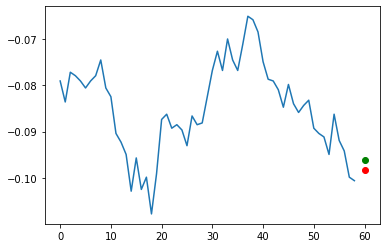

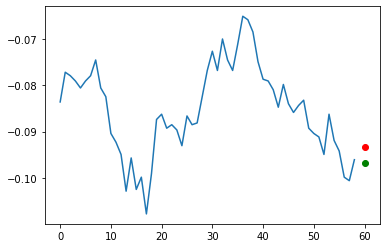

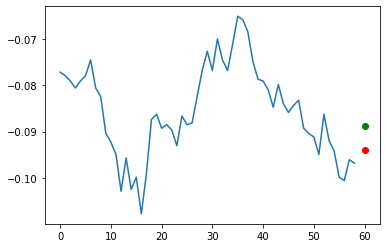

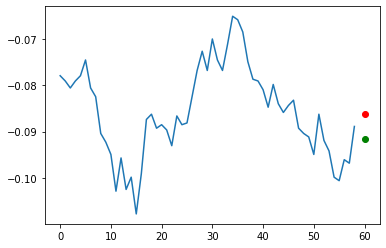

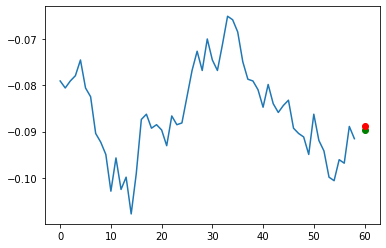

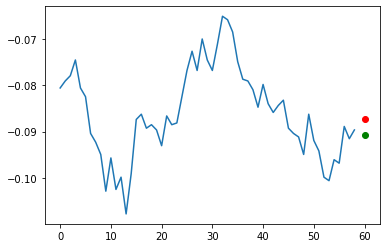

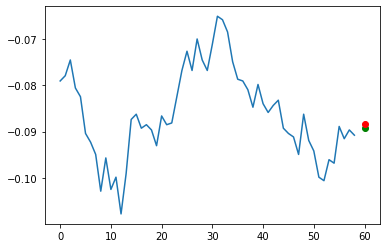

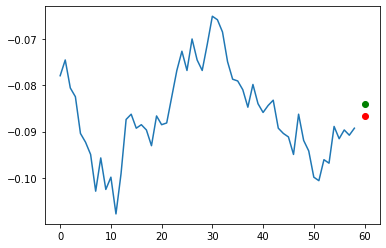

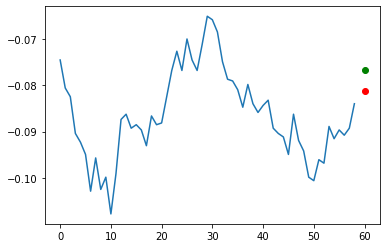

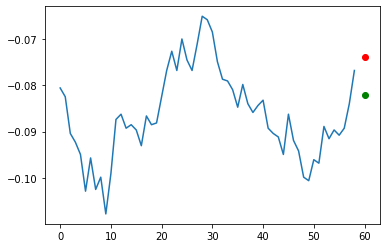

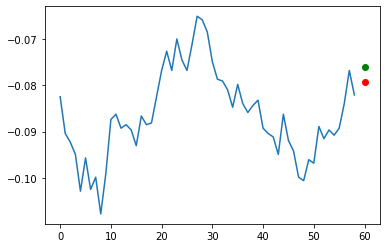

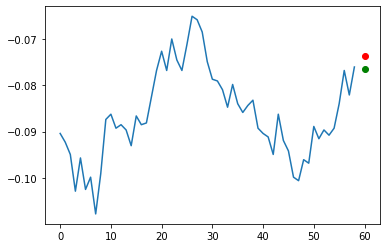

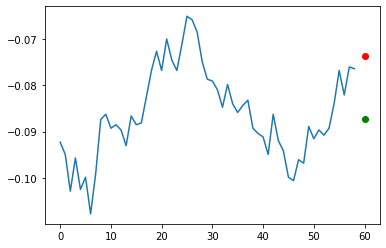

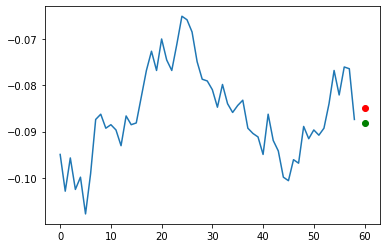

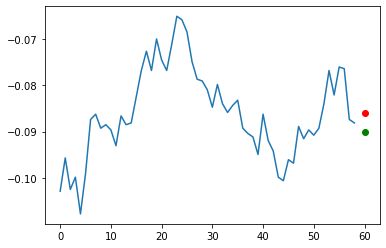

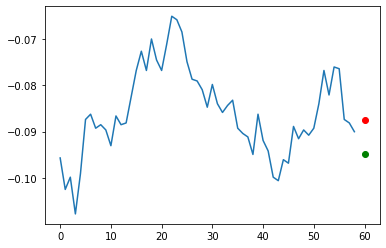

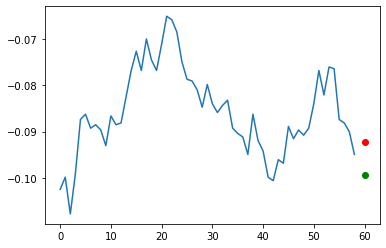

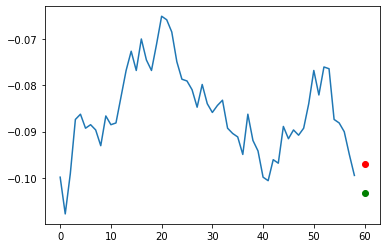

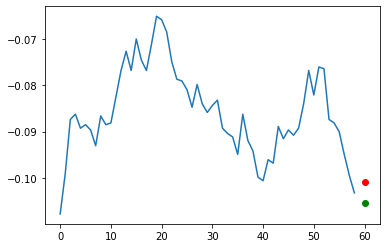

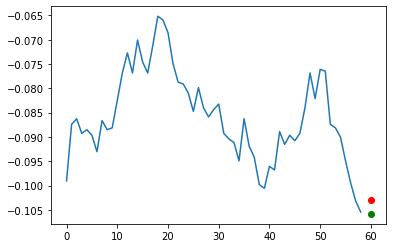

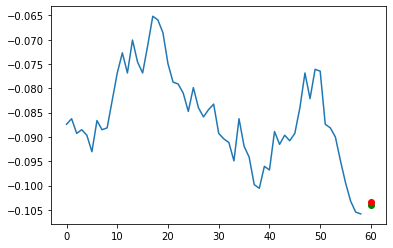

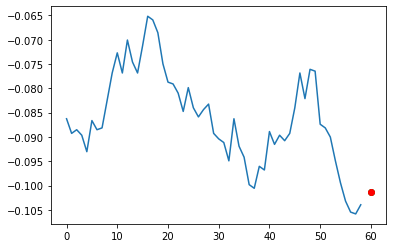

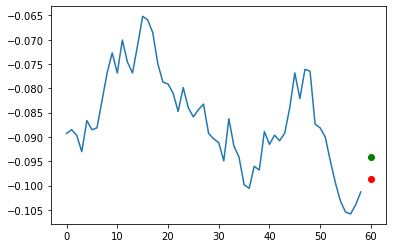

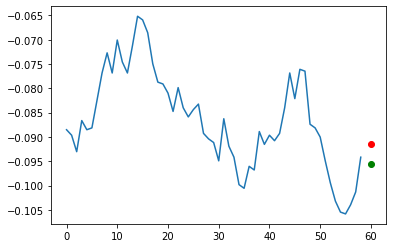

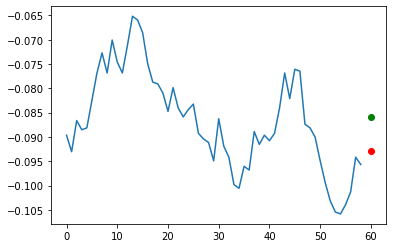

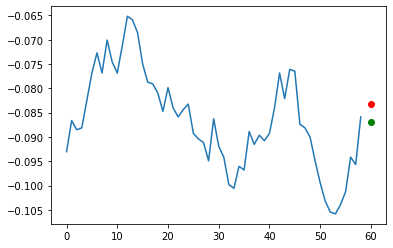

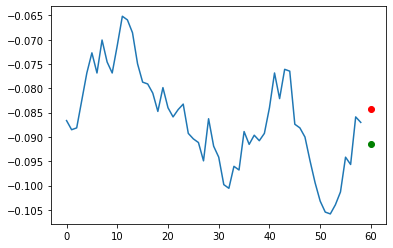

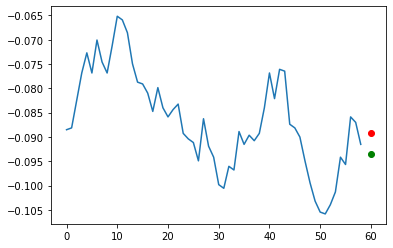

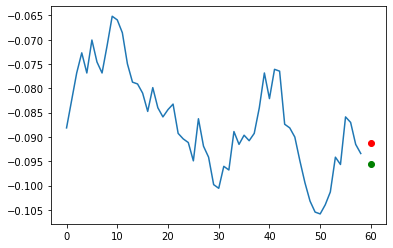

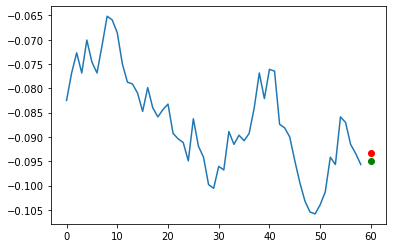

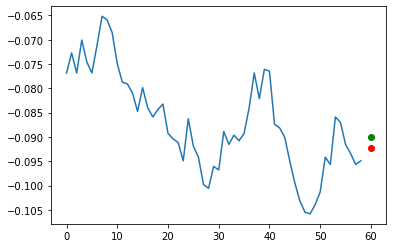

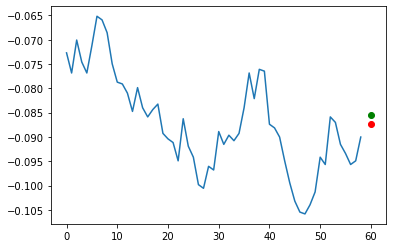

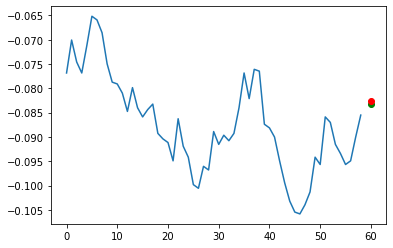

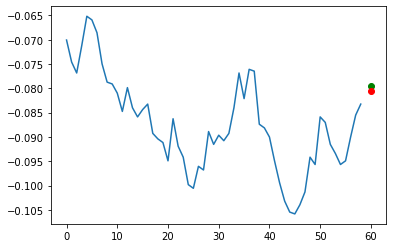

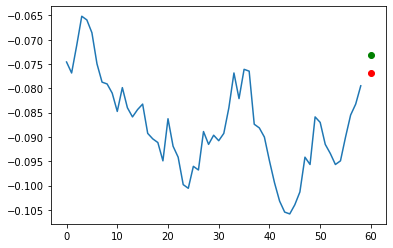

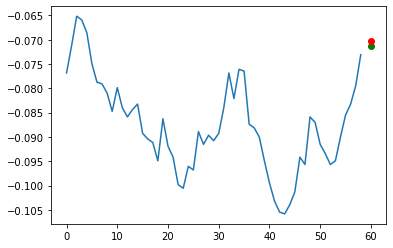

In [20]:
for idx in range(50):
    plt.plot(fold_val_batch_X[idx].to('cpu').reshape((-1,)))
    plt.scatter(60,fold_val_batch_y[idx].to('cpu').reshape((-1,)), color='green')
    plt.scatter(60, np.mean(fold_val_batch_X_pred[idx].to('cpu').detach().numpy().reshape((-1,))), color='red')
    plt.show()

In [45]:
loss

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward>)

In [30]:
list(range(1))

[0]

In [21]:
?filter

In [23]:
# Inverse transform the predictions
predictions = scaler.inverse_transform(fold_val_batch_X_pred.cpu().detach().numpy())
y_test = scaler.inverse_transform(fold_val_batch_y.cpu().detach().numpy())
y_test = y_test.reshape((-1,1))

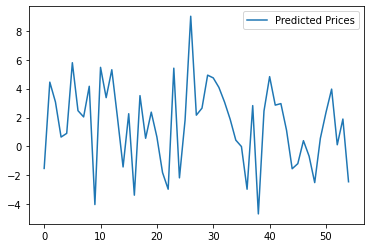

In [25]:
plt.plot((predictions - y_test).reshape((-1,)), label='Predicted Prices')
plt.legend()
plt.show()